### 使用有限多个辅助比特，在LimTDD上实现了态制备 结合了Alg.2和Alg.3 - 对应 Alg. 4

In [1]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing,get_index_order
from TDD.TDD import get_the_map_header
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate


to_test = False

In [2]:
computed_table_pre = dict()
computed_table_pre['g'] = dict() #global
computed_table_pre['b'] = dict() #borderc_control
computed_table_pre['s'] = dict() #single
computed_table_pre['m'] = dict() #multi-control
computed_table_pre['d'] = dict() #dif-branceh
computed_table_pre['r'] = dict() #merge 
computed_table_pre['n'] = dict() #non-reduce
def simulate(cir,ini=False,n=0):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
    # n = get_real_qubit_num(cir)
    if n!=0:
        add_inputs(tn,[0]*n,n)
    
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for k1 in range(n):
            if not 'x'+str(k1) in var:
                var.append('x'+str(k1))
            for k in range(5*len(all_indexs)):
                s ='x'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)               
            if not 'y'+str(k1) in var:
                var.append('y'+str(k1))
        var.reverse()
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)
        # computed_table_pre = dict()
        # computed_table_pre['g'] = dict()
        # computed_table_pre['b'] = dict()
        # computed_table_pre['s'] = dict()
        # computed_table_pre['m'] = dict()
        # computed_table_pre['d'] = dict()
        # computed_table_pre['r'] = dict()
        # computed_table_pre['n'] = dict()
#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd,tdd1)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    # temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    temp_tdd = Slicing2(tdd,tdd.node.key,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

def get_gate_data(cir):
    data = {}
    for d in cir.data:
        a = len(d.qubits)
        if a in data:
            data[a]+=1
        else:
            data[a]=1
    return data

def get_gate_data2(cir):
    data = 0
    for d in cir.data:
        data += len(d.qubits)
    return data

In [3]:
def get_meas_prob(node):
    if node.meas_prob!=[]:
        return
    if node.key==-1:
        return
    if node.key==0:
        node.meas_prob = [abs(node.out_weight[0])**2,abs(node.out_weight[1])**2]
        return
    if node.successor[0].meas_prob==[]:
        get_meas_prob(node.successor[0])
    if node.successor[1].meas_prob==[]:
        get_meas_prob(node.successor[1])
    node.meas_prob.append(abs(node.out_weight[0])**2*sum(node.successor[0].meas_prob))
    node.meas_prob.append(abs(node.out_weight[1])**2*sum(node.successor[1].meas_prob))
    node.successor[0].ref+=1
    # if node.successor[1]!=node.successor[0]:
    node.successor[1].ref+=1

    return

# def set_ref_2_zero(node):
#     node.ref=0
#     if node.key==-1:
#         return
#     set_ref_2_zero(node.successor[0])
#     set_ref_2_zero(node.successor[1])
#     return

# def get_ref_num(node):
#     if node.key==-1:
#         return
#     get_ref_num(node.successor[0])
#     get_ref_num(node.successor[1])
#     node.successor[0].ref+=1
#     node.successor[1].ref+=1
#     return

In [4]:
def get_branch_dd(u,c):
    bran_tdd = TDD(u.successor[c])
    n2 = bran_tdd.node.key+1
    bran_tdd.index_set = []
    bran_tdd.key_2_index ={-1:-1}
    bran_tdd.key_width = {}
    for k in range(n2):
        bran_tdd.index_set.append(Index('y'+str(k),0))
        bran_tdd.key_2_index[k] = 'y'+str(k)
        bran_tdd.key_width[k] = 2
    bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index} 
    return bran_tdd

def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    
    # if add_qubits_num==0:
    #     add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(len(cond))
        new_qubits = [k for k in cond]
        for k in qargs:
            new_qubits.append(k._index)
        for k in cond:
            if cond[k]==0:
                circ.x(k)
        circ.append(cg,new_qubits)
        for k in cond:
            if cond[k]==0:
                circ.x(k)        
    return circ
    
def state_pre2(tdd,n=0,qa = 0,cond={},anc_num=1):


    if tdd.node.key==-1:
        return QuantumCircuit(0),1
        
    if n==0:
        n = tdd.node.key+1
    cir = QuantumCircuit(n+1)
    # qa = n
    
    the_map=tdd.map

    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.x(q)
        if the_map.rotate>0:
            cir.p(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
    
    u = tdd.node
    the_map = u.out_maps[1]
    
    while the_map.level>-1:
        q1 = u.key
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.ccx(qa,q1,q)
        if the_map.rotate>0:
            cir.mcp(np.pi/4*(8-the_map.rotate),[qa, q1],q)
        the_map=the_map.father
    
    if u.successor[0]!=u.successor[1]:
        #把1分支关闭
        cond_qubit = [u.key] + [k for k in cond]
        for k in cond:
            if cond[k]==0:
                cir.x(k)
        # print('a',cond_qubit,qa)
        cir.mcx(cond_qubit,qa)
        for k in cond:
            if cond[k]==0:
                cir.x(k)
    
    # cond[u.key]=0
        bran_tdd = get_branch_dd(u,0)
        cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n,qa,cond|{u.key:0},anc_num)
        cir=cir&cir_end_t0
    
    # if u.successor[0]!=u.successor[1]:
        #把0分支关闭，1分支打开
        cond_qubit = [k for k in cond]
        if len(cond_qubit)==0:
            cir.x(qa)
        else:
            for k in cond:
                if cond[k]==0:
                    cir.x(k)
            # print('b',cond_qubit,qa)
            cir.mcx(cond_qubit,qa)
            for k in cond:
                if cond[k]==0:
                    cir.x(k)
                    
        bran_tdd = get_branch_dd(u,1)
        cir_end_t1, hold_prob1 = state_pre2(bran_tdd,n,qa,cond|{u.key:1},anc_num)
        cir=cir&cir_end_t1
        
        #把0分支再打开
        cond_qubit = [u.key] + [k for k in cond]
        cir.x(u.key)
        for k in cond:
            if cond[k]==0:
                cir.x(k)     
        # print('c',cond_qubit,qa)
        cir.mcx(cond_qubit,qa)
        for k in cond:
            if cond[k]==0:
                cir.x(k)
        cir.x(u.key)
    else:
        bran_tdd = get_branch_dd(u,0)
        cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n,qa,cond,anc_num)
        cir=cir&cir_end_t0
        hold_prob1 = hold_prob0        
        
    w0 = u.out_weight[0]*hold_prob0
    w1 = u.out_weight[1]*hold_prob1
    a=w1/w0
    M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
    u3 = UnitaryGate(M)
    cu3 = u3.control(1)
    cir.append(cu3,[qa,u.key])
    hold_prob = w0*np.sqrt(1+abs(a)**2)
    return cir, hold_prob




def state_pre(tdd,anc_num=0):
    global S, node_qubit

    if anc_num==0:
        print('Need at least one ancilla qubit')
        return 
    Q = [tdd.node]
    S=[]
    control_cond = {}
    
    n = tdd.node.key+1
    cir = QuantumCircuit(n+anc_num)
    anc_avi = n
    node_qubit = {}
    # set_ref_2_zero(tdd.node)
    get_meas_prob(tdd.node)

    the_map=tdd.map
    # print(the_map)
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.x(q)        
        if the_map.rotate>0:
            cir.p(np.pi/4*(8-the_map.rotate),q) 
        # print(q)
        the_map=the_map.father
    # print(the_map)
    while len(Q)>0:
        u = Q.pop(0)
        S.append(u)
        if not u in node_qubit and anc_avi<n+anc_num-1:
            node_qubit[u] = anc_avi
            anc_avi+=1
            
        if u in node_qubit:
            the_map = u.out_maps[1]
            while the_map.level>-1:
                q0 = node_qubit[u]
                q1 = u.key
                idx = the_map.level
                q = int(tdd.key_2_index[idx][1:])
                if not q0>q1>q:
                    the_map=the_map.father
                    continue
                if the_map.x==1:
                    cir.ccx(q0,q1,q)                
                if the_map.rotate>0:
                    cir.mcp(np.pi/4*(8-the_map.rotate),[q0,q1],q)
                # print([q0,q1],q)
                the_map=the_map.father
        
        u.successor[0].ref-=1
        if u.successor[0].key>-1 and not u.successor[0] in node_qubit and anc_avi<n+anc_num-1:
            node_qubit[u.successor[0]] = anc_avi
            anc_avi+=1
        if u.successor[0].key>-1 and u.successor[0] in node_qubit:
            cir.x(u.key)
            cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
            cir.x(u.key)
        if u.successor[0].ref==0 and u.successor[0].key>-1 and u.successor[0] in node_qubit:
            Q.append(u.successor[0])

        u.successor[1].ref-=1
        if u.successor[1].key>-1 and not u.successor[1] in node_qubit and anc_avi<n+anc_num-1:
            node_qubit[u.successor[1]] = anc_avi
            anc_avi+=1
        if u.successor[1].key>-1 and u.successor[1] in node_qubit:
            cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
        if u.successor[1].ref==0 and u.successor[1].key>-1 and u.successor[1] in node_qubit:
            Q.append(u.successor[1])
            
            
    for k in range(len(S)-1,-1,-1):
        u=S[k]
        if not u in node_qubit:# if only one ancilla qubit is given
            tdd_c =tdd.self_copy()
            tdd_c.map = get_the_map_header()
            cir_end_t0, hold_prob0 = state_pre2(tdd_c,n+anc_num-1,n+anc_num-1)
            cir=cir&cir_end_t0
            return cir
            
        if u.successor[0]==u.successor[1] and not u.successor[0] in node_qubit and u.successor[0].key!=-1:
            bran_tdd = get_branch_dd(u,0)
            cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n+anc_num-1,n+anc_num-1)
            cir_end_t0 = get_controlled_circuit2(cir_end_t0,cond = {node_qubit[u]:1},add_qubits_num = 0)
            cir=cir&cir_end_t0
            u.successor[0].hold_prob = hold_prob0
            u.successor[1].hold_prob = hold_prob0
        else:
            if u.successor[0].key>-1:
                if not u.successor[0] in node_qubit:
                    bran_tdd = get_branch_dd(u,0)
                    cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n+anc_num-1,n+anc_num-1)
                    cir_end_t0 = get_controlled_circuit2(cir_end_t0,cond = {node_qubit[u]:1,u.key:0},add_qubits_num = 0)
                    cir=cir&cir_end_t0
                    u.successor[0].hold_prob = hold_prob0
                else:
                    cir.x(u.key)
                    cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
                    cir.x(u.key)
            
            if u.successor[1].key>-1:
                if not u.successor[1] in node_qubit:
                    bran_tdd = get_branch_dd(u,1)
                    cir_end_t1, hold_prob1 = state_pre2(bran_tdd,n+anc_num-1,n+anc_num-1)
                    cir_end_t1 = get_controlled_circuit2(cir_end_t1,cond = {node_qubit[u]:1,u.key:1},add_qubits_num = 0)
                    cir=cir&cir_end_t1
                    u.successor[1].hold_prob = hold_prob1                
                else:
                    cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])


        w0 = u.out_weight[0]*u.successor[0].hold_prob
        w1 = u.out_weight[1]*u.successor[1].hold_prob
        # a = u.out_weight[1]
        a=w1/w0
        M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
        u3 = UnitaryGate(M)
        cu3 = u3.control(1)
        cir.append(cu3,[node_qubit[u],u.key])
        u.hold_prob = w0*np.sqrt(1+abs(a)**2)

    return cir

def extend_tdd(tdd,anc_num=0):
    var=[]
    q_n = tdd.node.key+1+anc_num
    for k1 in range(q_n):
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)

    U0=np.array([1,0])
    U1=np.array([0,1])
    tdd_new = tdd.self_copy()
    for q in range(tdd.node.key+1,q_n,1):
        if q==tdd.node.key+1 or q==q_n-1:
            ts=Tensor(U1,[Index('y'+str(q))],'out',[k])
        else:
            ts=Tensor(U0,[Index('y'+str(q))],'out',[k])
        tdd_new=cont(tdd_new,ts.tdd())
    return tdd_new

def is_zero_state(node):
    if node.key==0:
        return True
    if node.successor[0]!=node.successor[1]:
        return False
    if node.out_weight[0]!=1 or node.out_weight[1]!=0:
        return False
    if node.out_maps[1].level!=-1:
        return False
    return is_zero_state(node.successor[0])
    
def is_successful(tdd,n,anc_num):
    if tdd.map.level!=n+anc_num-1:
        return False
    if tdd.map.x!=1:
        return False
    if tdd.map.rotate!=0:
        return False
    the_map = tdd.map.father
    if anc_num>1:
        if the_map.level!=n:
            return False
        if the_map.x!=1:
            return False
        if the_map.rotate!=0:
            return False
        if the_map.father.level!=-1:
            return False
    else:
        if the_map.level!=-1:
            return False
    return is_zero_state(tdd.node)

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2'}


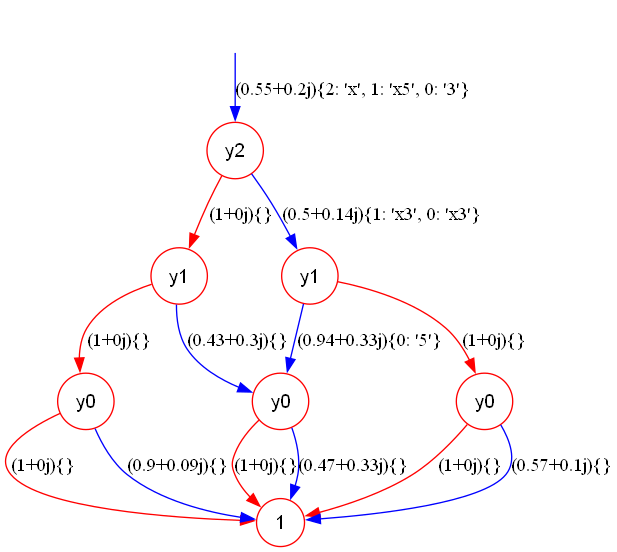

In [5]:
n=3
m=100

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
tdd=renormalize(tdd)
tdd.show()

C:\Users\23626\AppData\Local\Temp\ipykernel_9060\1761894217.py:21: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir.data:


True


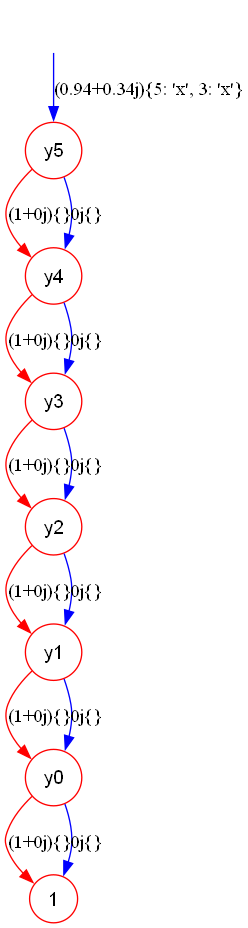

In [6]:
anc_num = 3

cir_head = QuantumCircuit(n+anc_num)
cir_end = state_pre(tdd.self_copy(),anc_num)
# print('1')
tdd_new = extend_tdd(tdd,anc_num)
# print('2')
tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
# print('3')
tdd_new2 = renormalize(tdd_new2)
# print('4')
print(is_successful(tdd_new2,n,anc_num))
tdd_new2.show()

In [7]:
n=3
m=100
g_num = 0
g_num2=0
g_num3=0
r = 20
tt = 0
for k in range(r):
    # if k%10==0:
    print(k)
    k+=1
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,True,n)
    print('node:',tdd2.node_number())
    cir_head = QuantumCircuit(n+anc_num)
    t_start=time.time()
    cir_end = state_pre(tdd2,anc_num)
    print(time.time()-t_start) #只统计态制备的时间，以及所生成电路的复杂度
    tdd_new = extend_tdd(tdd2,anc_num)
    tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
    tdd_new2 = renormalize(tdd_new2)
    if not is_successful(tdd_new2,n,anc_num):
        print('find_one')
        break


0
node: 4
0.08738851547241211


C:\Users\23626\AppData\Local\Temp\ipykernel_9060\1761894217.py:21: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir.data:


1
node: 4
0.07276129722595215
2
node: 4
0.08353281021118164
3
node: 8
0.4590775966644287
4
node: 6
0.2261803150177002
5
node: 4
0.05742931365966797
6
node: 7
0.4159364700317383
7
node: 4
0.07070207595825195
8
node: 6
0.22205591201782227
9
node: 4
0.028743743896484375
10
node: 7
0.5668845176696777
11
node: 4
0.06820487976074219
12
node: 6
0.39940476417541504
13
node: 4
0.050169944763183594
14
node: 6
0.1579127311706543
15
node: 8
0.5499188899993896
16
node: 5
0.33443140983581543
17
node: 6
0.2029552459716797
18
node: 8
0.5561251640319824
19
node: 6
0.1988825798034668
